### Начинаем учебные соревнования 

13 марта 2023 года, https://www.kaggle.com/

### Импортируем полезные библиотеки

In [564]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, GridSearchCV

import pandas as pd

import matplotlib.pyplot as plt

import seaborn as sns

from datetime import datetime

%matplotlib inline

from sklearn import tree

from IPython.display import SVG
from graphviz import Source
from IPython.display import display
import numpy as np

from IPython.display import HTML
style = "<style>svg{width:30% !important;height:30% !important;}</style>"
HTML(style)

from sklearn.model_selection import train_test_split

from sklearn.model_selection import cross_val_score, GridSearchCV

from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score


### Открыть файлы

1) Посмотреть файлы в архиве zip (имя и размер)

In [534]:
from zipfile import ZipFile

ZipFile('/Users/tony_builder/Documents/GitHub/kaggle/datas/store-sales-time-series-forecasting.zip').infolist()

[<ZipInfo filename='holidays_events.csv' compress_type=deflate file_size=22309 compress_size=2232>,
 <ZipInfo filename='oil.csv' compress_type=deflate file_size=20580 compress_size=5822>,
 <ZipInfo filename='sample_submission.csv' compress_type=deflate file_size=342153 compress_size=65352>,
 <ZipInfo filename='stores.csv' compress_type=deflate file_size=1387 compress_size=490>,
 <ZipInfo filename='test.csv' compress_type=deflate file_size=1022269 compress_size=152503>,
 <ZipInfo filename='train.csv' compress_type=deflate file_size=121800373 compress_size=21820633>,
 <ZipInfo filename='transactions.csv' compress_type=deflate file_size=1552637 compress_size=368309>]

2. Считать конкретный файл в zip архиве и прочитать его (например через pandas.read)

In [ ]:
import pandas as pd

with ZipFile('/Users/tony_builder/Documents/GitHub/kaggle/datas/store-sales-time-series-forecasting.zip', 'r') \
    as zip_file:
    holiday_df = pd.read_csv(zip_file.open('holidays_events.csv'))
    oil_df = pd.read_csv(zip_file.open('oil.csv'))
    sample_submission_df = pd.read_csv(zip_file.open('sample_submission.csv'))
    test = pd.read_csv(zip_file.open('test.csv'))
    train = pd.read_csv(zip_file.open('train.csv'))
    transactions = pd.read_csv(zip_file.open('transactions.csv'))
    stores_df = pd.read_csv(zip_file.open('stores.csv'))



### Задать цель

Описание: 
1) есть тренировочные данные , содержащие продукцию, о которых известно:
- идентификационный номер товара
- дата его продажи **с 1 января 2013 по 15 августа 2017**
- место его продажи (номер магазина)
- к чему относится этот товар (авто, красота, морепродукты, книги и пр)
- рекламировался ли он в конкретную дату
- какой объем продаж товара сделан в конкретную дату
2) Целевая переменная - непосредственно количество продаж товара
3) вспомогательные датасэты содержат дополнительную инфу (например об общей выручке магазина, которую он делал в конкретную дату) или информация о праздниках



Файл для предсказаний: информация о продаваемых товарах в последующие 15 дней 
- **с 16 августа 2017 по 31 августа 2017**

Что нужно:

        предсказать целевую переменную (объем продаж) некоторых семейств товаров в конкретные даты и в конкретных магазинах, зная информацию о том, как будет рекламироваться товар в эти даты

Стратегия:
1) наполнить тренировочный датасэт данными:
- информацию о том, является ли день продажи выходным (теоретически, в выходные дни продажи выше, чем в обычные)

- информация о стоимости на нефть в текущий день - т.к продажи товаров так же могут зависеть от цены на нефть

- Заработная плата в бюджетной сфере выплачивается каждые две недели 15 числа и в последний день месяца. Это может повлиять на продажи в супермаркетах.

- Землетрясение магнитудой 7,8 произошло в Эквадоре 16 апреля 2016 года (15 неделя года). Люди объединились для оказания помощи, пожертвовав воду и другие предметы первой необходимости, что сильно повлияло на продажи в супермаркетах в течение нескольких недель после землетрясения.

###  Работаем с датасетом по праздникам

In [ ]:

holiday_df['datetime'] = pd.to_datetime(holiday_df.date, format='%Y-%m-%d')
holiday_df =  holiday_df.drop('date',axis=1)\
.rename(columns={'datetime':'date'})\
[['date', 'type', 'locale', 'locale_name', 'description', 'transferred']]

holiday_df['year'] = holiday_df.date.dt.year
holiday_df['month'] = holiday_df.date.dt.month
holiday_df['day'] = holiday_df.date.dt.day

holiday_df

,date,type,locale,locale_name,description,transferred,year,month,day
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False,2012,3,2
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False,2012,4,1
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False,2012,4,12
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False,2012,4,14
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False,2012,4,21
...,...,...,...,...,...,...,...,...,...
345,2017-12-22,Additional,National,Ecuador,Navidad-3,False,2017,12,22
346,2017-12-23,Additional,National,Ecuador,Navidad-2,False,2017,12,23
347,2017-12-24,Additional,National,Ecuador,Navidad-1,False,2017,12,24
348,2017-12-25,Holiday,National,Ecuador,Navidad,False,2017,12,25


Что знаем о таблице праздников:
1) Holiday 
- National: 8 перенесенных (рабочие дни для всех! ) и 52 без переноса (праздник для всех)
- Regional: 24 праздника только для некоторых ШТАТОВ
- Local: 4 перенесенных (рабочие дни для ВСЕХ!) и 133 без переноса (нерабочие только для некоторых ГОРОДОВ)

2) Event и Bridge :  61 нерабочие для всех

3) Additional: 
- National: 40 праздники для всех
- Local: 11 праздники для некоторых ГОРОДОВ

4) Transfer:
- National: 8 дней нерабочие для всех
- Local : 4 дня нерабочие только для некоторых ГОРОДОВ

5) Work day - РАБОЧИЕ для всех, даже если это суббота или воскресенье


Нужно разделить все дни на два типа: **праздничный/непраздничный**


        Разделим таблицу (350 дней) на несколько частей:
        - нерабочие для всех
        - нерабочие для городов
        - нерабочие для штатов
        - рабочие не взирая на то, что это суббота

In [ ]:
# нерабочие для всех (161 день за все годы)
holidays_for_all = holiday_df[holiday_df.locale == 'National'].\
    query("transferred == False").\
    query("type != 'Work Day' ")

holidays_for_all['workday'] = holidays_for_all.transferred.map(int)

holidays_for_all.head()

,date,type,locale,locale_name,description,transferred,year,month,day,workday
14,2012-08-10,Holiday,National,Ecuador,Primer Grito de Independencia,False,2012,8,10,0
20,2012-10-12,Transfer,National,Ecuador,Traslado Independencia de Guayaquil,False,2012,10,12,0
21,2012-11-02,Holiday,National,Ecuador,Dia de Difuntos,False,2012,11,2,0
22,2012-11-03,Holiday,National,Ecuador,Independencia de Cuenca,False,2012,11,3,0
31,2012-12-21,Additional,National,Ecuador,Navidad-4,False,2012,12,21,0


список праздников для всех содержит дубликаты по датам, но они все государственные и неперенесенные, поэтому их все можно смело дропнуть

In [ ]:
# найти все дубликаты в столбце датасэта и вывести на экран
holidays_for_all[holidays_for_all.duplicated('date')]

,date,type,locale,locale_name,description,transferred,year,month,day,workday
36,2012-12-24,Additional,National,Ecuador,Navidad-1,False,2012,12,24,0
40,2012-12-31,Additional,National,Ecuador,Primer dia del ano-1,False,2012,12,31,0
157,2014-12-26,Additional,National,Ecuador,Navidad+1,False,2014,12,26,0
236,2016-05-01,Event,National,Ecuador,Terremoto Manabi+15,False,2016,5,1,0
243,2016-05-07,Event,National,Ecuador,Terremoto Manabi+21,False,2016,5,7,0
245,2016-05-08,Event,National,Ecuador,Dia de la Madre,False,2016,5,8,0


In [ ]:
# нерабочие для городов (148 дней за все годы)

holidays_for_cities = holiday_df[holiday_df.locale == 'Local'].\
    query("transferred == False").\
    query("type != 'Work Day' ")

holidays_for_cities['workday'] = holidays_for_cities.transferred.map(int)


holidays_for_cities.head()


# здесь дубликаты дат нельзя удалять, потому что эти даты могут быть праздничными сразу для двух городов,
# а значит для нескольких магазинов

,date,type,locale,locale_name,description,transferred,year,month,day,workday
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False,2012,3,2,0
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False,2012,4,12,0
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False,2012,4,14,0
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False,2012,4,21,0
5,2012-05-12,Holiday,Local,Puyo,Cantonizacion del Puyo,False,2012,5,12,0


In [376]:
# переименуем столбец locale_name в столбец city для удобства слияния
holidays_for_cities = holidays_for_cities.rename(columns={'locale_name': 'city'})

,date,type,locale,city,description,transferred,year,month,day,workday
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False,2012,3,2,0
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False,2012,4,12,0
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False,2012,4,14,0
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False,2012,4,21,0
5,2012-05-12,Holiday,Local,Puyo,Cantonizacion del Puyo,False,2012,5,12,0
...,...,...,...,...,...,...,...,...,...,...
338,2017-11-12,Holiday,Local,Ambato,Independencia de Ambato,False,2017,11,12,0
339,2017-12-05,Additional,Local,Quito,Fundacion de Quito-1,False,2017,12,5,0
341,2017-12-08,Holiday,Local,Loja,Fundacion de Loja,False,2017,12,8,0
342,2017-12-08,Transfer,Local,Quito,Traslado Fundacion de Quito,False,2017,12,8,0


In [479]:
# нерабочие для штатов (24 дня за все годы)

holidays_for_states = holiday_df[holiday_df.locale == 'Regional']

# добавим столбец нерабочих дней
holidays_for_states['workday'] = holidays_for_states.transferred.map(int)

# переименуем locale_name в имя штата (в этой таблице остались только имена штатов)
holidays_for_states = holidays_for_states.rename(columns= {'locale_name': 'state'})
holidays_for_states

/var/folders/9t/0d2y6zvs0pn1b5hks81yn5jw0000gn/T/ipykernel_71953/1123250828.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  holidays_for_states['workday'] = holidays_for_states.transferred.map(int)


,date,type,locale,state,description,transferred,year,month,day,workday
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False,2012,4,1,0
7,2012-06-25,Holiday,Regional,Imbabura,Provincializacion de Imbabura,False,2012,6,25,0
23,2012-11-06,Holiday,Regional,Santo Domingo de los Tsachilas,Provincializacion de Santo Domingo,False,2012,11,6,0
24,2012-11-07,Holiday,Regional,Santa Elena,Provincializacion Santa Elena,False,2012,11,7,0
47,2013-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False,2013,4,1,0
58,2013-06-25,Holiday,Regional,Imbabura,Provincializacion de Imbabura,False,2013,6,25,0
76,2013-11-06,Holiday,Regional,Santo Domingo de los Tsachilas,Provincializacion de Santo Domingo,False,2013,11,6,0
77,2013-11-07,Holiday,Regional,Santa Elena,Provincializacion Santa Elena,False,2013,11,7,0
96,2014-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False,2014,4,1,0
112,2014-06-25,Holiday,Regional,Imbabura,Provincializacion de Imbabura,False,2014,6,25,0


In [491]:
# рабочие для всех (17 дней за все годы): либо перенесенные праздники , либо замененные на рабочие дни

workdays_for_all = holiday_df[(holiday_df.type == 'Work Day') | (holiday_df.transferred == True)]
workdays_for_all.head()

,date,type,locale,locale_name,description,transferred,year,month,day
19,2012-10-09,Holiday,National,Ecuador,Independencia de Guayaquil,True,2012,10,9
42,2013-01-05,Work Day,National,Ecuador,Recupero puente Navidad,False,2013,1,5
43,2013-01-12,Work Day,National,Ecuador,Recupero puente primer dia del ano,False,2013,1,12
72,2013-10-09,Holiday,National,Ecuador,Independencia de Guayaquil,True,2013,10,9
135,2014-10-09,Holiday,National,Ecuador,Independencia de Guayaquil,True,2014,10,9


### Работаем с тренировочным датасэтом: наполняем данными о выходных и рабочих днях

In [ ]:
train['datetime'] = pd.to_datetime(train.date, format='%Y-%m-%d')
train =  train.drop('date',axis=1)\
.rename(columns={'datetime':'date'})\
[['id', 'date', 'store_nbr', 'family', 'onpromotion', 'sales']]

#train['year'] = train.date.dt.year
#train['month'] = train.date.dt.month
#train['day'] = train.date.dt.day
train['week_day'] = train.date.dt.day_of_week

train

,id,date,store_nbr,family,onpromotion,sales,week_day
0,0,2013-01-01,1,AUTOMOTIVE,0,0.000,1
1,1,2013-01-01,1,BABY CARE,0,0.000,1
2,2,2013-01-01,1,BEAUTY,0,0.000,1
3,3,2013-01-01,1,BEVERAGES,0,0.000,1
4,4,2013-01-01,1,BOOKS,0,0.000,1
...,...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,0,438.133,1
3000884,3000884,2017-08-15,9,PREPARED FOODS,1,154.553,1
3000885,3000885,2017-08-15,9,PRODUCE,148,2419.729,1
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,8,121.000,1


Объединим данные по продажам с данными:
- о том, где находятся магазины (город,штат)
- о том, какие из этих дней являются праздничными, причем даты Holidays yужно отфильтровать в диапазон (01.01.23 - 15.08.17), потому что train data имеет именно такой диапазон

In [ ]:
# примерджим в датасэт train информацию о местонахождении магазинов
train_filled = train.merge(stores_df, on='store_nbr', 
            how='outer').drop(['type', 'cluster'], axis=1)

# Отберем только тот диапазон дней, который соответствует тренировочному датасэту, уберем дубликаты дат
holiday_temp = holidays_for_all[(holidays_for_all.date <= '2017-08-15') &\
                                        (holidays_for_all.date >='2013-01-01')]\
                                        [['date', 'workday']].\
                                        drop_duplicates('date')

# добавим столбец, описывающий - выходной это день или рабочий
train_filled['workday'] = train_filled['date'].map(holiday_temp.set_index('date')['workday'])

train_filled


,id,date,store_nbr,family,onpromotion,sales,week_day,city,state,workday
0,0,2013-01-01,1,AUTOMOTIVE,0,0.000,1,Quito,Pichincha,0.0
1,1,2013-01-01,1,BABY CARE,0,0.000,1,Quito,Pichincha,0.0
2,2,2013-01-01,1,BEAUTY,0,0.000,1,Quito,Pichincha,0.0
3,3,2013-01-01,1,BEVERAGES,0,0.000,1,Quito,Pichincha,0.0
4,4,2013-01-01,1,BOOKS,0,0.000,1,Quito,Pichincha,0.0
...,...,...,...,...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,0,438.133,1,Quito,Pichincha,NaN
3000884,3000884,2017-08-15,9,PREPARED FOODS,1,154.553,1,Quito,Pichincha,NaN
3000885,3000885,2017-08-15,9,PRODUCE,148,2419.729,1,Quito,Pichincha,NaN
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,8,121.000,1,Quito,Pichincha,NaN


Объединяем информацию о праздниках в некоторых городах с тренировочным датасетом
- получится два столбца workday - потому что мы мерджим две таблицы по столбцам ДАТА и ГОРОД, но в эьтих таблицах в обеих присутствует столбец WORKDAY, поэтому появятся дубли столбцов

- чтобы привести в нормальный вид - нужно все значения NAN  в столбце  Х заполнить  значениями из столбца У
- а теперь дропнуть ненужные столбцы Х и У

Остались дубликаты - 264 строки:
- убедимся, что это дубликаты по ID
- проверим, что это действительно полная копия тех строк, что уже есть (через dupicates('id')) - и удалим все эти строки

In [469]:
train_filled = pd.merge(train_filled,
                  holidays_for_cities[['date', 'city', 'workday']], 
                  how='left', 
                  on=['date', 'city'])

train_filled['workday'] = train_filled['workday_y'].fillna(train_filled['workday_x'])
train_filled = train_filled.drop(['workday_x', 'workday_y'], axis=1)

train_filled = train_filled.drop_duplicates('id')

train_filled

,id,date,store_nbr,family,onpromotion,sales,week_day,city,state,workday
0,0,2013-01-01,1,AUTOMOTIVE,0,0.000,1,Quito,Pichincha,0.0
1,1,2013-01-01,1,BABY CARE,0,0.000,1,Quito,Pichincha,0.0
2,2,2013-01-01,1,BEAUTY,0,0.000,1,Quito,Pichincha,0.0
3,3,2013-01-01,1,BEVERAGES,0,0.000,1,Quito,Pichincha,0.0
4,4,2013-01-01,1,BOOKS,0,0.000,1,Quito,Pichincha,0.0
...,...,...,...,...,...,...,...,...,...,...
3001147,3000883,2017-08-15,9,POULTRY,0,438.133,1,Quito,Pichincha,NaN
3001148,3000884,2017-08-15,9,PREPARED FOODS,1,154.553,1,Quito,Pichincha,NaN
3001149,3000885,2017-08-15,9,PRODUCE,148,2419.729,1,Quito,Pichincha,NaN
3001150,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,8,121.000,1,Quito,Pichincha,NaN


Аналогично примерджим сюда информацию о праздниках, которые действительны только в НЕКОТОРЫХ штатах

In [488]:
train_filled = pd.merge(train_filled,
                  holidays_for_states[['date', 'state', 'workday']], 
                  how='left', 
                  on=['date', 'state'])

train_filled['workday'] = train_filled['workday_y'].fillna(train_filled['workday_x'])
train_filled = train_filled.drop(['workday_x', 'workday_y'], axis=1)


train_filled

,id,date,store_nbr,family,onpromotion,sales,week_day,city,state,workday
0,0,2013-01-01,1,AUTOMOTIVE,0,0.000,1,Quito,Pichincha,0.0
1,1,2013-01-01,1,BABY CARE,0,0.000,1,Quito,Pichincha,0.0
2,2,2013-01-01,1,BEAUTY,0,0.000,1,Quito,Pichincha,0.0
3,3,2013-01-01,1,BEVERAGES,0,0.000,1,Quito,Pichincha,0.0
4,4,2013-01-01,1,BOOKS,0,0.000,1,Quito,Pichincha,0.0
...,...,...,...,...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,0,438.133,1,Quito,Pichincha,NaN
3000884,3000884,2017-08-15,9,PREPARED FOODS,1,154.553,1,Quito,Pichincha,NaN
3000885,3000885,2017-08-15,9,PRODUCE,148,2419.729,1,Quito,Pichincha,NaN
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,8,121.000,1,Quito,Pichincha,NaN


Осталось указать два типа дней:
- рабочие дни несмотря ни на что
- нерабочие дни суббота и воскресенье

Остальные дни автоматически будут рабочими

In [526]:
# фильтруем тренировоочный датасет по значениям: 
# - если день недели 5 или 6 (суббота или воскресенье) 
# - если этот день не один из дней, которые являются рабочими для всех!
# ставим отрицание(чтобы получить все оставшиеся значения) и указываем, что для всех остальных применить значение 0

# и в конце концов заполняем все оставшиеся значения NAN единицами - это РАБОЧИЕ дни

train_filled.workday = train_filled.workday.where\
    (~((train_filled.week_day.isin([5,6])) & (~train_filled.date.isin(workdays_for_all.date))), 
    other= 0)\
    .fillna(1)

# в итоге получаем датасет, в котором каждому дню присвоено значение 1/0 (рабочий/нерабочий)
# всего нерабочих: 1 020 855 дней за весь период
# всего рабочих: 1 980 033 дней за весь период
train_filled.groupby('workday').agg({'id':'count'})



,id
workday,
0.0,1020855
1.0,1980033


**ВАЖНО ПОМНИТЬ!** дни могут быть нерабочими только для некоторых штатов или городов!

### Тренировочный датасет: наполняем информацией о выплате запрплаты работникам

In [529]:
train_filled

,id,date,store_nbr,family,onpromotion,sales,week_day,city,state,workday
0,0,2013-01-01,1,AUTOMOTIVE,0,0.000,1,Quito,Pichincha,0.0
1,1,2013-01-01,1,BABY CARE,0,0.000,1,Quito,Pichincha,0.0
2,2,2013-01-01,1,BEAUTY,0,0.000,1,Quito,Pichincha,0.0
3,3,2013-01-01,1,BEVERAGES,0,0.000,1,Quito,Pichincha,0.0
4,4,2013-01-01,1,BOOKS,0,0.000,1,Quito,Pichincha,0.0
...,...,...,...,...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,0,438.133,1,Quito,Pichincha,1.0
3000884,3000884,2017-08-15,9,PREPARED FOODS,1,154.553,1,Quito,Pichincha,1.0
3000885,3000885,2017-08-15,9,PRODUCE,148,2419.729,1,Quito,Pichincha,1.0
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,8,121.000,1,Quito,Pichincha,1.0


Просуммируем все продажи применительно к каждому дню и каждому магазину

Цель: выявить как меняются продажи в зависимости от выплаты зарплаты дважды в месяц

In [585]:
# вспомогательная функция для вывода распределения объема продаж для каждого магазина в конкретном году

def sales_in_year(store, year, alldays=False):
      from datetime import datetime
      start, end = datetime(year,1,1), datetime(year,12,31)

      # суммируем продажи по каждой дате для каждого магазина
      temp_df = train_filled.groupby(['date', 'store_nbr'], as_index=False).agg({'sales': 'sum'}).\
            query("@start <= date <= @end ").\
            query("store_nbr == @store")\
            .drop('store_nbr', axis=1)
      
      # добавим графу недели для читабельности
      temp_df['weeks'] = temp_df.date.dt.isocalendar().week
      # присоединим последние два дня года  к 52 неделе
      temp_df.weeks = temp_df.weeks.where(~(temp_df.date.isin(['2013-12-30', '2013-12-31'])), 
                                                other= 52)
      
      # итоговый датасет (с неделями или по каждому дню) вывести в зависсимости от показателя alldays:
      # - если alldays=False по умолчанию, то вывести только для недель
      # - если alldays =True (прописать), то вывести для каждого дня
      result_df = (temp_df.groupby('weeks', as_index=False).agg({'sales':'sum'}), 
                   temp_df)\
                   [alldays]
      
      xlab = ('weeks', 'date')[alldays]


      return result_df


In [652]:
# вспомогательная функция построения распределения выручки для каждого магазина в каждом году

def sales_in_year_plot(store, year, alldays=False):
    xlab = ('weeks', 'date')[alldays]
    # зададим размер графика для читабельности
    sns.set(rc={'figure.figsize': (12,6)}) 
    
    return sales_in_year(store,year, alldays=False).\
        set_index('weeks').\
        sales.plot(kind='bar', xlabel=xlab)

Поиграв с номерами магазинов и годами можно убедиться в том, что:
- с начала года до 49 недели наблюдается относительно равномерная картина выручки
- в конце года в основном выручка заметно вырастает (предпраздниные покупки , начиная с 49 недели)

- в 2016 году на 15 неделе действительно наблюдается рост покупок после землетрясения

- на неделе, предшествующей зарплатной неделе, продажи обычно снижаются, люди экономят

- есть годы, в которых наблюдается резкий скачок продаж в году, который не снижается до самого конца (полагаю, связано с ростом стоимости на нефть)

<AxesSubplot: xlabel='weeks'>

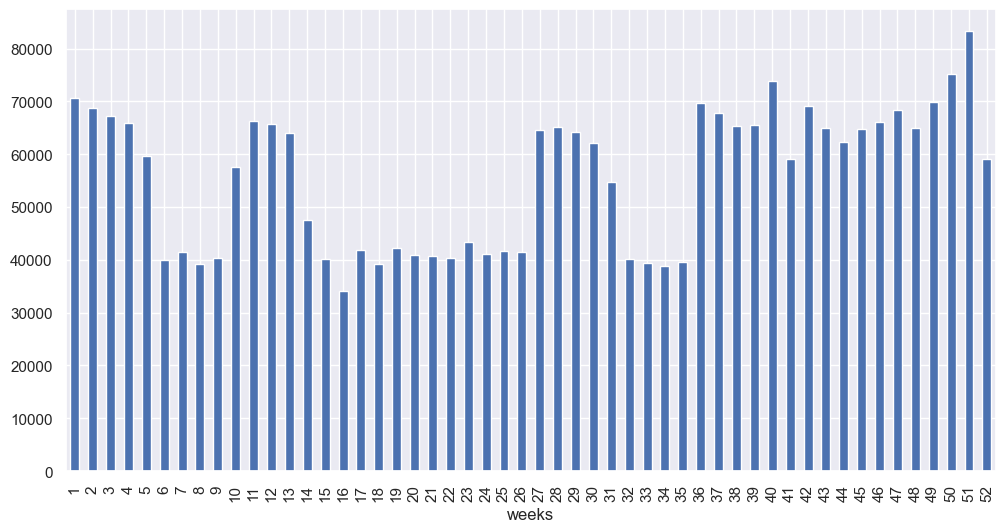

In [655]:
sales_in_year_plot(store=1, year=2014)

### Тренировочный датасет: наполняем данными о стоимости нефти

In [631]:
# сначала обработаем исходный датасет по нефти: поменяем дату, заполним пустые значения котировки(цены) на предыдущее

oil_df['date_dt'] = pd.to_datetime(oil_df.date)
oil_df = oil_df.drop('date', axis=1).rename(columns={'date_dt':'date'})[['date','dcoilwtico']]
oil_df= oil_df.fillna(method='ffill').fillna(93.14)

# добавим столбцы год и месяц
oil_df['year'] = oil_df.date.dt.year
oil_df['month'] = oil_df.date.dt.month

oil_df


,date,dcoilwtico,year,month
0,2013-01-01,93.14,2013,1
1,2013-01-02,93.14,2013,1
2,2013-01-03,92.97,2013,1
3,2013-01-04,93.12,2013,1
4,2013-01-07,93.20,2013,1
...,...,...,...,...
1213,2017-08-25,47.65,2017,8
1214,2017-08-28,46.40,2017,8
1215,2017-08-29,46.46,2017,8
1216,2017-08-30,45.96,2017,8


Построим распределение усредненной цены  нефти по годам и месяцам

In [648]:
# зададим размер графика для читабельности
sns.set(rc={'figure.figsize': (12,6)}) 

<AxesSubplot: xlabel='year_month'>

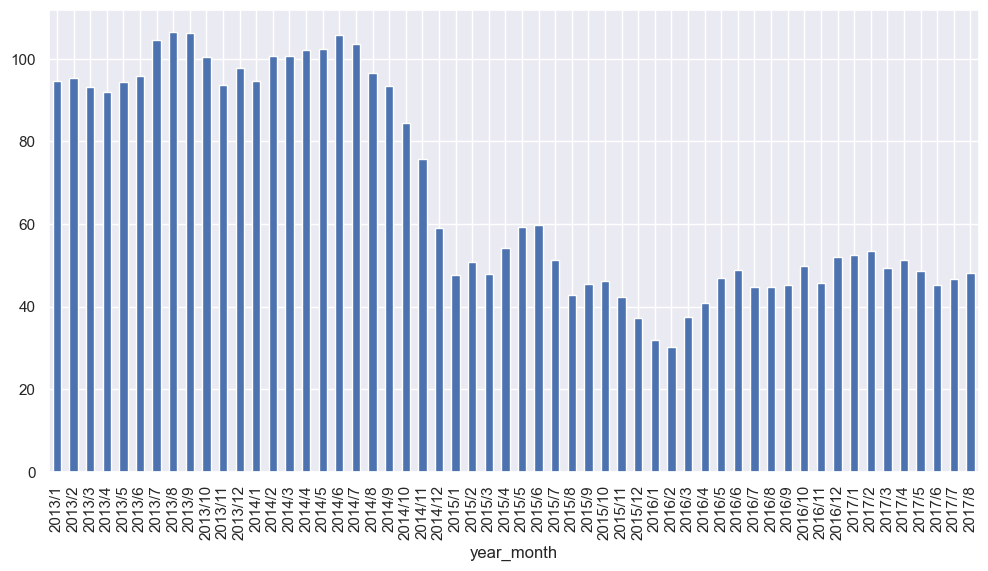

In [647]:
oil_year_month =  oil_df.groupby(['year', 'month'], as_index=False).agg({'dcoilwtico': 'mean'})

oil_year_month['year_month'] = oil_year_month.year.map(str) + '/' + oil_year_month.month.map(str)

oil_year_month.set_index('year_month').dcoilwtico.plot(kind='bar')


Заведем столбец со значениями изменения цены нефти ото дня к дню, выраженную в процентах

In [694]:
# отличный способ пройтись по всей таблице и посчитать разницу между соседними значениями 
# - с помощью метода rolling() скользящее окно 
# в качестве функции указываем разницу между соседними значениями и считаем процент разницы 

oil_df['difference_percent'] = oil_df.dcoilwtico.rolling(2).\
                                apply(lambda x: round((x.iloc[1] - x.iloc[0])/x.iloc[1]*100, 2)).\
                                fillna(0)

oil_df = oil_df[['date', 'dcoilwtico', 'difference_percent', 'year', 'month']]

oil_df

,date,dcoilwtico,difference_percent,year,month
0,2013-01-01,93.14,0.00,2013,1
1,2013-01-02,93.14,0.00,2013,1
2,2013-01-03,92.97,-0.18,2013,1
3,2013-01-04,93.12,0.16,2013,1
4,2013-01-07,93.20,0.09,2013,1
...,...,...,...,...,...
1213,2017-08-25,47.65,0.86,2017,8
1214,2017-08-28,46.40,-2.69,2017,8
1215,2017-08-29,46.46,0.13,2017,8
1216,2017-08-30,45.96,-1.09,2017,8


In [527]:
train_filled

,id,date,store_nbr,family,onpromotion,sales,week_day,city,state,workday
0,0,2013-01-01,1,AUTOMOTIVE,0,0.000,1,Quito,Pichincha,0.0
1,1,2013-01-01,1,BABY CARE,0,0.000,1,Quito,Pichincha,0.0
2,2,2013-01-01,1,BEAUTY,0,0.000,1,Quito,Pichincha,0.0
3,3,2013-01-01,1,BEVERAGES,0,0.000,1,Quito,Pichincha,0.0
4,4,2013-01-01,1,BOOKS,0,0.000,1,Quito,Pichincha,0.0
...,...,...,...,...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,0,438.133,1,Quito,Pichincha,1.0
3000884,3000884,2017-08-15,9,PREPARED FOODS,1,154.553,1,Quito,Pichincha,1.0
3000885,3000885,2017-08-15,9,PRODUCE,148,2419.729,1,Quito,Pichincha,1.0
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,8,121.000,1,Quito,Pichincha,1.0


### Тренировочный датасет: учитываем информацию о влиянии землетрясения 